# Singular Value Decomposition

Author: Michael Greer

This notebook discusses the singular values of the Jacobian and their affect on the operation of a manipulator. Singular value analysis is often applied when discussing the "Manipulability" of a robot arm or how well that robot arm can maneuver within the task space.

The concepts presented in this notebook are demonstrated using planar manipulators; they can be abstracted to any workspace.

Singular Value Decomposition has many other applications in other fields, but this notebook focuses on applications in robotic manipulators.

In [4]:
import numpy as np
from numpy import cos, sin, pi

import matplotlib.pyplot as plt

import sympy as sp

### Forward Kinematics and Jacobian

To start things off, we define functions to perform forward kinematics, plot the robot, and find the Jacobain. These functions are copied directly from previous notebooks, so feel free to skip to the next section.

In [5]:
# The final parameter is a list of 2d vectors to draw from the tip of the manipulator
def plot_robot(links, joints, vecs):
    
    colorlist = ['r', 'b', 'g']
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    xs = [0]
    ys = [0]
    
    total_len = sum(links) * 1.2
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        xs.append(xs[-1] + l * cos(total_q))
        ys.append(ys[-1] + l * sin(total_q))
        
    plt.figure(figsize=(8,8))
    plt.plot(xs, ys)
    
    for i, vec in enumerate(vecs):
        
        plt.arrow(xs[-1], ys[-1], vec[0], vec[1], length_includes_head=True,head_width=0.2, head_length=0.2, color = colorlist[i])
    
    plt.ylim(-1 * total_len, total_len)
    plt.xlim(-1 * total_len, total_len)
    plt.title('Robot Manipulator Pose')
    
    return

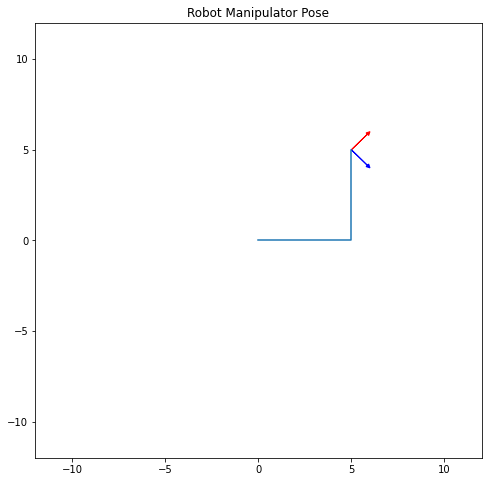

In [6]:
# Change the joint values to see how the arm moves, with two arbitrary vectors drawn

plot_robot([5, 5], [0, pi/2], [[1, 1], [1, -1]])

In [7]:
def f_kine(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
    
    x = 0
    y = 0
    
    total_len = sum(links)
    
    total_q = 0
    
    for l,q in zip(links, joints):
        
        total_q += q
        
        x += l * cos(total_q)
        y += l * sin(total_q)
        
    return np.array([[x],[y]])

In [8]:
def jacobian(links, joints):
    
    # Convert to list if it's an ndarray
    if (isinstance(joints, np.ndarray)):
        joints = joints.flatten().tolist()
            
    # Form symbolic q matrix
    
    qs = []
    
    for i in range(0,len(joints)):
        
        qs.append(sp.Symbol('q{}'.format(i)))
        
        
    jac = np.zeros((2, len(links)))
    
    x = 0
    y = 0
    
    # Form forward kinematics
    for i in range(len(links)):
                   
        total_q = 0
        
        for j in range(i + 1):
            
            total_q += qs[j]
            
        x += links[i] * sp.cos(total_q)
        y += links[i] * sp.sin(total_q)
        
    
    # Differentiate to find jacobian      
    for i in range(len(links)):
        
        Jx = sp.diff(x, qs[i])
        Jy = sp.diff(y, qs[i])
        
        for k in range(len(links)):
            
            Jx = Jx.subs(qs[k], joints[k])
            Jy = Jy.subs(qs[k], joints[k])
                
        jac[0,i] = Jx.evalf()
        jac[1,i] = Jy.evalf()
            
    return jac

### Singular Value Decomposition

Now that we've defined some functions to use, let's dive into Singular Value Decomposition (SVD). While SVD is generally not covered in linear algebra introduction courses, the concept of eigendecomposition is usually introduced. These two decompositions are similar in the sense that they tell us something about the nature of the original matrix. The general form of the SVD is written as:

$$A=U\Sigma V^{T}$$

Where $U$ and $V$ are both orthonormal matrices, and $\Sigma$ is a diagonal matrix containing real, non-negative entries. These values along the diagonal are called the singular values of the matrix. Using these entries, we can describe this as:

$$A = \begin{bmatrix} u_{1}  & u_{2} & \dots & u_{n} \end{bmatrix} 
\begin{bmatrix} \sigma_{1} & 0 & \dots & 0 \\ 0 & \sigma_{2} & \dots & 0 \\ \vdots & \vdots & \ddots & \\ 0 & 0 & & \sigma_{n}\end{bmatrix}
\begin{bmatrix} v_{1}  & v_{2} & \dots & v_{n} \end{bmatrix}^{T}$$

This is the definition of the SVD of a square matrix but, as we will see later, this process is also applicable to non-square matrices.

To understand the SVD, remember that any matrix is a linear transformation operator that maps from an input space to an output space. In the specific case of robotic manipulators, the Jacobian is a transformation that maps from the joint velocity space to the task velocity space. The SVD of the Jacobian contains useful information about the relationship between these two spaces.

Let's first consider the case of a square matrix. The columns of the $U$ matrix are associated with vectors in the output space, and the columns of the $V$ matrix are associated with columns of the input space. For a square Jacobian, each input vector has a corresponding output vector and singular value. Both of these vectors are of unit length, and the related singular value describes the gain caused by the transformation. This relationship is written as:

$$Av_{i} = \sigma_{i}u_{i}$$

The way the SVD is computed, there are aspects that are important about this relationship: 
1. the singular values are always arranged in descending order along the diagonal. 
2. The first singular value describes the greatest possible gain of the transformation. 
3. Each following singular value describes the greatest possible gain achieved by an input vector that is mutually perpendicular to all previous input vectors in $V$.

### Application to Robotics

We can use this information to analyze the behavior of a manipulator at a certain pose. Let's look at the manipulator from earlier in this document. We will find the Jacobian, perform SVD, and plot the resultant input and output vectors.

[[-0.85065081  0.52573111]
 [ 0.52573111  0.85065081]]
[[8.09016994 0.        ]
 [0.         3.09016994]]
[[ 0.85065081  0.52573111]
 [ 0.52573111 -0.85065081]]


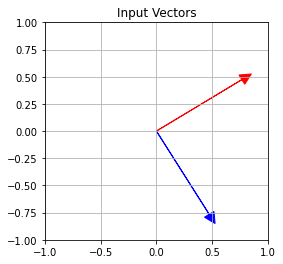

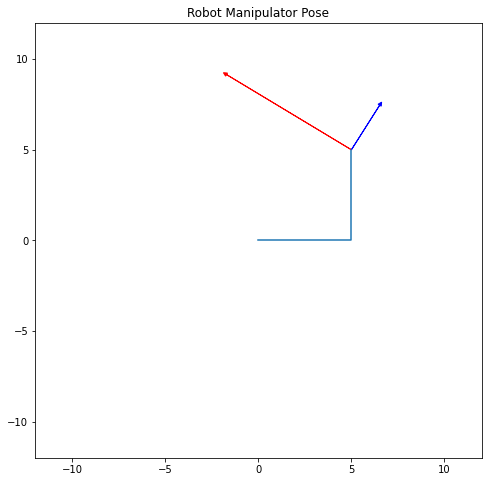

In [9]:
links = [5, 5]
joints = [0, pi/2]

jac = jacobian(links, joints)


u, s, vt = np.linalg.svd(jac)

v = vt.T

print(u)
print(np.diag(s))
print(v)

plt.figure(figsize=(4,4))
plt.grid()
plt.title("Input Vectors")
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.arrow(0, 0, v[0,0], v[1,0], length_includes_head=True,head_width=0.1, head_length=0.1, color = 'r')
plt.arrow(0, 0, v[0,1], v[1,1], length_includes_head=True,head_width=0.1, head_length=0.1, color = 'b')

plot_robot(links, joints, [[s[0] * u[0,0], s[0] * u[1,0]], [s[1] * u[0,1], s[1] * u[1,1]]])

Let's talk about these plots. 

In the first plot, we've shown both components of the $V$ matrix. The horizontal axis corresponds to movement of the first joint and the vertical axis corresponds to movement of the second. *Note: both of these vectors are perpendicular and of unit length.*

On the last plot, we've plotted both elements of the $U$ matrix scaled by the singular values at the end of the manipulator. Remember that the Jacobian describes instantaneous velocity, so the lengths of these arrows do not show where the manipulator will move but rather how fast it will move for the corresponding input. *Note: both of these are perpendicular.*

The colors indicate which vectors correspond between the graphs. From earlier we know that if we multiply one of the vectors in the first plot by the Jacobian, the result will be one of the vectors in the second plot. Let's verify that with the vectors shown in red.

In [10]:
print(jac @ v[:,0])
print(s[0] * u[:,0])

[-6.8819096   4.25325404]
[-6.8819096   4.25325404]


Would you look at that, they're exactly the same! One important property is that these vectors are symmetrical, meaning if we negate the input vector, the output vector will also be negated. If we consider the input space as a set of all possible input vectors of unit length (a circle around the origin), the output space appears as an ellipse with major axis $u_{1}$ and minor axis $u_{2}$. This is often referred to as the "Manipulability Ellipsoid" and is often employed to visualize the manipulability at a certain pose. 

### Singularity
You may have guessed the direction this notebook is going from the title, so yes; we are going to discuss singularity. The issue of singularity in robotics is often poorly defined in lecture, leaving students with an incimplete understanding. By evaluating the manipulator configuration using SVD, we arrive at a mathematically rigorous definition of a singular configuration.

One common type of singularity that is easier to understand is the type that occurs at the edge of a workspace, when the arm is fully extended. Let's consider a near-singular configuration of this type:

[[-0.059976    0.99819982]
 [ 0.99819982  0.059976  ]]
[[11.16692683  0.        ]
 [ 0.          0.22350244]]
[[ 0.89433755  0.44739282]
 [ 0.44739282 -0.89433755]]


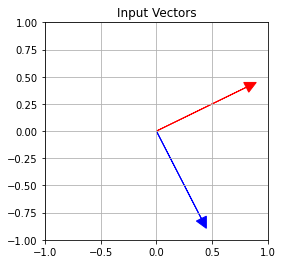

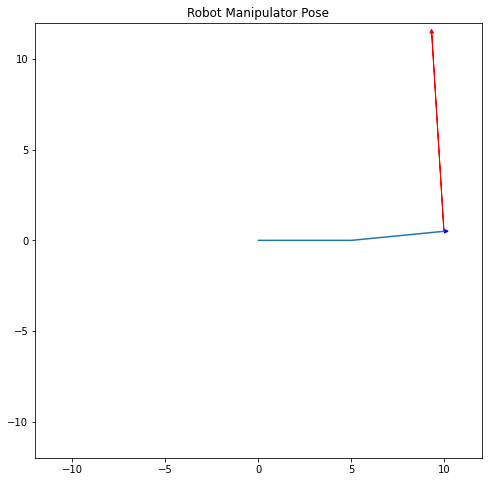

In [11]:
links = [5, 5]
joints = [0, 0.1]

jac = jacobian(links, joints)


u, s, vt = np.linalg.svd(jac)

v = vt.T

print(u)
print(np.diag(s)) # Numpy gives the singular values in a vector instead of a matrix
print(v)

plt.figure(figsize=(4,4))
plt.grid()
plt.title("Input Vectors")
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.arrow(0, 0, v[0,0], v[1,0], length_includes_head=True,head_width=0.1, head_length=0.1, color = 'r')
plt.arrow(0, 0, v[0,1], v[1,1], length_includes_head=True,head_width=0.1, head_length=0.1, color = 'b')

plot_robot(links, joints, [[s[0] * u[0,0], s[0] * u[1,0]], [s[1] * u[0,1], s[1] * u[1,1]]])

In this instance, the end effector of the robot is near the edge of it's workspace, and we can see that the resultant second singular value has shrunk considerably. This reflects the fact that, while it is still easy to move in the $u_{1}$ direction, it is very difficult to move in the $u_{2}$ direction. It would require a large joint velocity to generate a slight joint velocity in this workspace direction. Finally, let's look and see what happens when the configuration is singular:

[[ 0. -1.]
 [-1.  0.]]
[[11.18033989  0.        ]
 [ 0.          0.        ]]
[[-0.89442719 -0.4472136 ]
 [-0.4472136   0.89442719]]


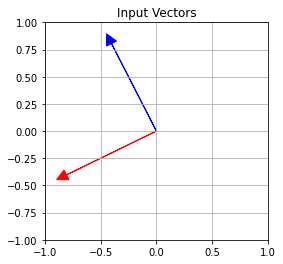

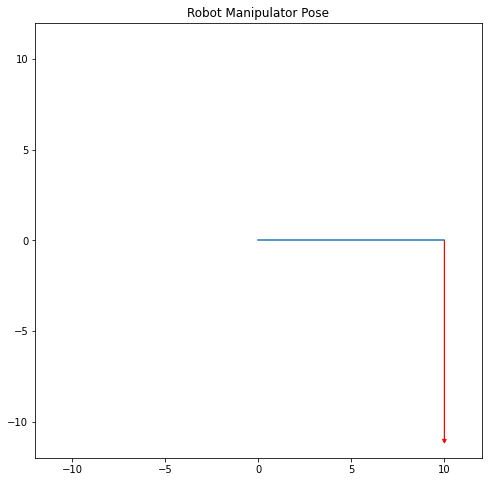

In [12]:
links = [5, 5]
joints = [0, 0]

jac = jacobian(links, joints)


u, s, vt = np.linalg.svd(jac)

v = vt.T

print(u)
print(np.diag(s))
print(v)

plt.figure(figsize=(4,4))
plt.grid()
plt.title("Input Vectors")
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.arrow(0, 0, v[0,0], v[1,0], length_includes_head=True,head_width=0.1, head_length=0.1, color = 'r')
plt.arrow(0, 0, v[0,1], v[1,1], length_includes_head=True,head_width=0.1, head_length=0.1, color = 'b')

plot_robot(links, joints, [[s[0] * u[0,0], s[0] * u[1,0]], [s[1] * u[0,1], s[1] * u[1,1]]])

Now, the second singular value is exactly zero. This means, that no matter what joint velocity we have at this configuration, it will never be possible for the end effector to move in the workspace direction associated with this singular value. Here we see the rigorous, mathematical definition of a singularity: when the minimum singular value of a matrix is equal to zero. 

### Non-Square Jacobian

Unlike eigendecomposition, SVD can be applied to non-square matrices. This is useful since we can use the same methods to evaluate the movement of redundant manipulators as we do non-redundant manipulators. The SVD looks a bit different here as well. Both $U$ and $V$ are both still square and orthonormal, but they are not the same size. $U$ is the dimension of the output space, and $V$ is the dimension of the input space. The $\Sigma$ matrix has the same dimensions as the original matrix. It has the singular values along the diagonal as before, and is padded with zeros to ensure that it has the correct dimensions. To show this, let's look at a manipulator with one degree of redundancy:

[[-0.95810614  0.28641338]
 [ 0.28641338  0.95810614]]
[[13.69070084  0.          0.        ]
 [ 0.          4.77521881  0.        ]]
[[ 0.73020189  0.60271243  0.32178085]
 [ 0.62560046 -0.4004941  -0.66949872]
 [ 0.27464387 -0.69017549  0.66949872]]


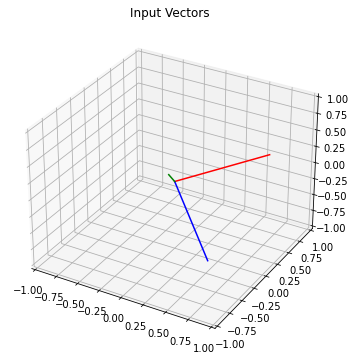

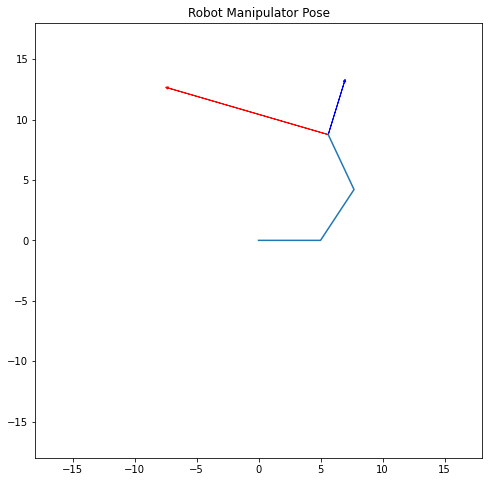

In [13]:
links = [5, 5, 5]
joints = [0, 1, 1]

jac = jacobian(links, joints)


u, s, vt = np.linalg.svd(jac)

v = vt.T

print(u)
print(np.hstack((np.diag(s), np.zeros((2,1)))))
print(v)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
plt.title("Input Vectors")

ax.plot([0, v[0, 0]], [0, v[1, 0]], [0, v[2, 0]], color="r")
ax.plot([0, v[0, 1]], [0, v[1, 1]], [0, v[2, 1]], color="b")
ax.plot([0, v[0, 2]], [0, v[1, 2]], [0, v[2, 2]], color="g")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plot_robot(links, joints, [[s[0] * u[0,0], s[0] * u[1,0]], [s[1] * u[0,1], s[1] * u[1,1]]])

It may be hard to see in the 3D plot above, but all three of the input vectors are still orthonormal. However, even though we now have three input vectors, we only have two output vectors. The meaning of the red and blue vectors remains unchanged, but the significance of the green vector hearkens back to a concept we explored in the last blog post: nullspace. Since this manipulator has one degree of redundancy, it has a nullspace of one dimension. We can see this by multiplying this vector by the Jacobian and seeing the results.

In [14]:
print(jac @ v[:,2])

[4.56135946e-16 2.78264980e-16]


While these don't display as exactly zero due to limitations present in computers, they are effectively zero. This suggests that this input vector generates no velocity of the end effector of the robot, i.e. the vector reads zero task space movement. Sometimes, you may see an option for an "economy" or reduced SVD, which omits the nullspace vectors and uses a square $\Sigma$ matrix. This process still maintains the exact original matrix, as shown below:

In [15]:
u_e = u
s_e = np.diag(s)
v_e = v[0:3,0:2] # Don't use the nullspace vector

print(u_e @ s_e @ v_e.T)
print(jac)

[[-8.75384206 -8.75384206 -4.54648713]
 [ 5.62077735  0.62077735 -2.08073418]]
[[-8.75384206 -8.75384206 -4.54648713]
 [ 5.62077735  0.62077735 -2.08073418]]


As shown above, no information about the original matrix is lost by using the reduced form. In data science, this process is useful for data reduction.

### Inverse and Pseudoinverse

The SVD can also be used to calculate the inverse and pseudoinverse of a matrix. Both $U$ and $V$ are orthonormal matrices, so the inverse is simply the transpose. Furthermore, since $\Sigma$ is a diagonal matrix, the inverse can be performed by inverting each of the diagonal elements, and taking the transpose in the case of a non-square $\Sigma$. So:

$$A^{-1} = V\Sigma^{-1}U^{T}$$

and for the general case:

$$A^{+} = V\Sigma^{+}U^{T}$$

We can see how this definition relates to the singularity definition from earlier. If the minimum singular value is zero, the $\Sigma$ matrix is non-invertable, thus the original matrix is non-invertable. In a previous blog posts, we used the Jacobian pseudoinverse to calculate the joint velocity for some desired task velocity. If the pseudoinverse does not exist, the desired task velocity is not possible in the current configuration.

### Conclusions

Singular Value Decomposition is a helpful tool for understanding the concepts of manipulability, as well as singular configurations. This method has analytical applications for both redundant and non-redundant manipulators.

### Appendix

For more information about SVD applications in robotics, see [here](https://www.engr.colostate.edu/~aam/pdf/journals/5.pdf).

Some media discuss manipulability in terms of eigenvalues and eigenvectors, but the math works out to the same end result. For more ways in which eigendecomposition and SVD are similar, see [here](https://www.cc.gatech.edu/~dellaert/pubs/svd-note.pdf).

For more information on the manipulability ellipsoid, she [here](https://modernrobotics.northwestern.edu/nu-gm-book-resource/5-4-manipulability/).

